In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings; warnings.simplefilter('ignore')
import os
for dirname, _, filenames in os.walk('/users/eunnyoung/work/kaggle/bike-sharing-demand/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/users/eunnyoung/work/kaggle/bike-sharing-demand/data\sampleSubmission.csv
/users/eunnyoung/work/kaggle/bike-sharing-demand/data\test.csv
/users/eunnyoung/work/kaggle/bike-sharing-demand/data\train.csv


## Load Data

In [2]:
train = pd.read_csv('/users/eunnyoung/work/kaggle/bike-sharing-demand/data/train.csv')
test = pd.read_csv('/users/eunnyoung/work/kaggle/bike-sharing-demand/data/test.csv')
submission = pd.read_csv('/users/eunnyoung/work/kaggle/bike-sharing-demand/data/sampleSubmission.csv')

print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


In [3]:
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

## EDA
### Target Variable

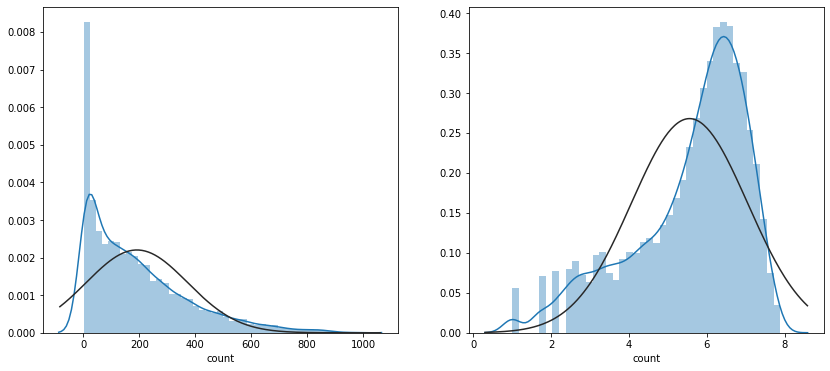

In [4]:
Ytrain = train['count']
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(Ytrain, ax=ax1, fit=norm)
sns.distplot(np.log(Ytrain)+1, ax=ax2, fit=norm)

### Missing Value

In [5]:
feature_names = list(test)
train = train[feature_names]
all_data = pd.concat((train, test))
print(train.shape, test.shape, all_data.shape)

(10886, 9) (6493, 9) (17379, 9)


In [6]:
all_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

### Datetime

In [7]:
all_data['datetime'] = pd.to_datetime(all_data['datetime'])
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['day'] = all_data['datetime'].dt.day
all_data['hour'] = all_data['datetime'].dt.hour
all_data['dayofweek'] = all_data['datetime'].dt.dayofweek
all_data = all_data.drop(columns = 'datetime')

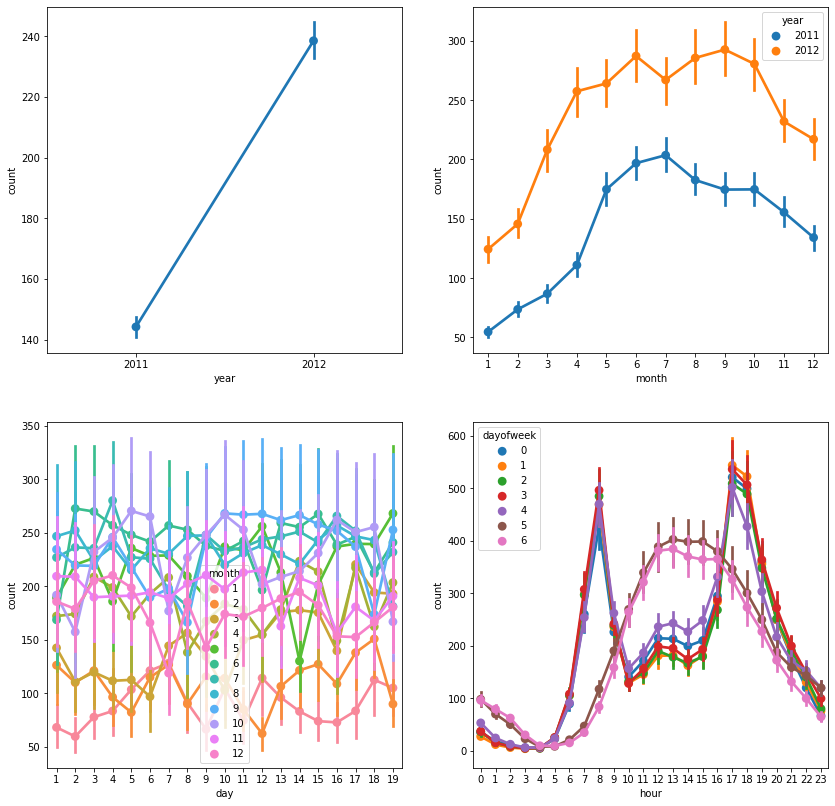

In [8]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,14)
sns.pointplot(data=all_data[:len(train)], x='year', y=Ytrain, ax=ax1)
sns.pointplot(data=all_data[:len(train)], x='month', y=Ytrain, ax=ax2, hue='year')
sns.pointplot(data=all_data[:len(train)], x='day', y=Ytrain, ax=ax3, hue='month')
sns.pointplot(data=all_data[:len(train)], x='hour', y=Ytrain, ax=ax4, hue='dayofweek')

In [9]:
all_data = all_data.drop(columns=['month', 'day'])

In [10]:
all_data['weekend'] = (all_data['dayofweek']==5) | (all_data['dayofweek']==6)

### Season

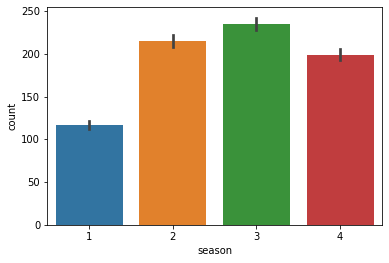

In [11]:
sns.barplot(data=all_data[:len(train)], x='season', y=Ytrain)

In [12]:
# pd.get_dummies ★
season_encoded = pd.get_dummies(all_data['season'], prefix='season_')
all_data = pd.concat((all_data, season_encoded), axis=1)
all_data = all_data.drop(columns='season')

### Holiday, Workingday

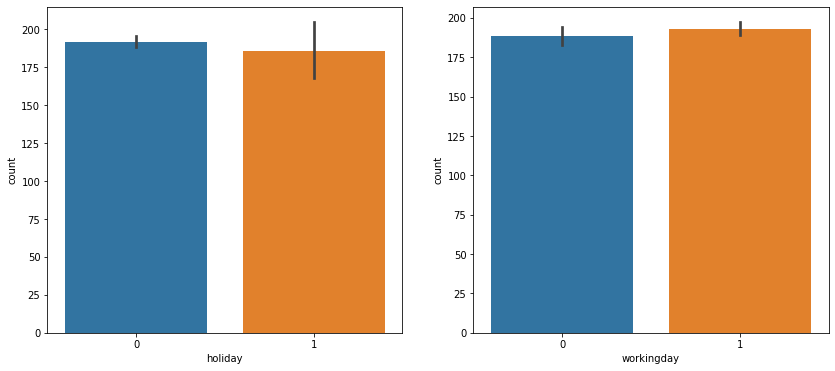

In [13]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.barplot(data=all_data[:len(train)], x='holiday', y=Ytrain, ax=ax1)
sns.barplot(data=all_data[:len(train)], x='workingday', y=Ytrain, ax=ax2)

### Weather

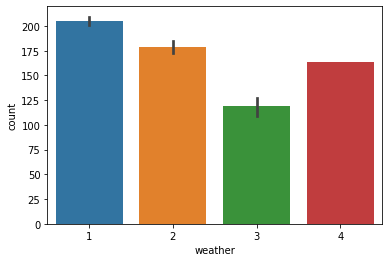

In [14]:
sns.barplot(data=all_data[:len(train)], x='weather', y=Ytrain)

In [15]:
# pd.get_dummies ★
weather_encoded = pd.get_dummies(all_data['weather'], prefix = 'weather_')
all_data = pd.concat((all_data, weather_encoded), axis=1)
all_data = all_data.drop(columns='weather')

### Temperature

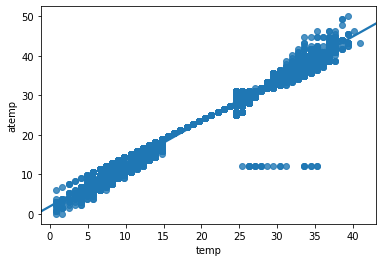

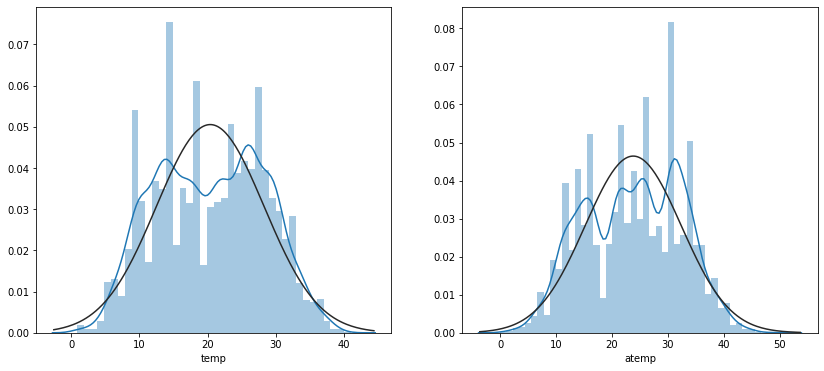

In [16]:
sns.regplot(data=all_data, x='temp', y='atemp')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(all_data['temp'], ax=ax1, fit=norm)
sns.distplot(all_data['atemp'], ax=ax2, fit=norm)

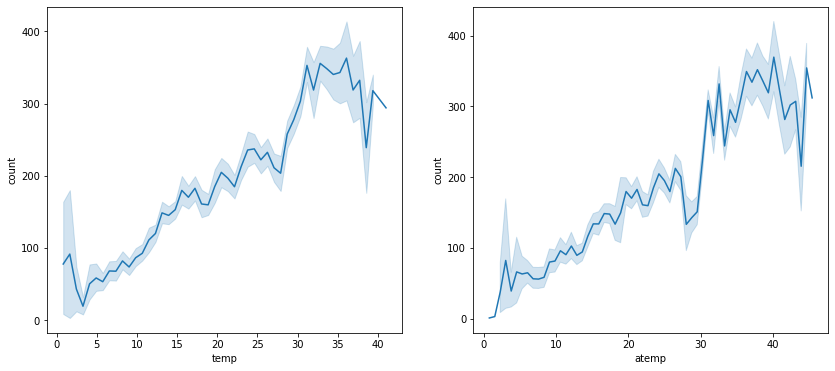

In [17]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.lineplot(data=all_data[:len(train)], x='temp', y=Ytrain, ax=ax1)
sns.lineplot(data=all_data[:len(train)], x='atemp', y=Ytrain, ax=ax2)

In [18]:
from sklearn.decomposition import PCA

In [19]:
# pca ★
pca = PCA(n_components=1)
pca.fit(all_data[['temp', 'atemp']])

print(f" Variance explained after PCA : {pca.explained_variance_ratio_}")

 Variance explained after PCA : [0.99388034]


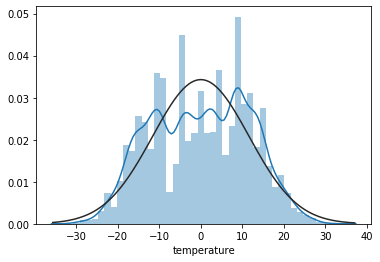

In [20]:
all_data['temperature'] = pca.fit_transform(all_data[['temp', 'atemp']])
sns.distplot(all_data['temperature'], fit=norm)

In [21]:
all_data = all_data.drop(columns=['temp', 'atemp'])

### Humidity

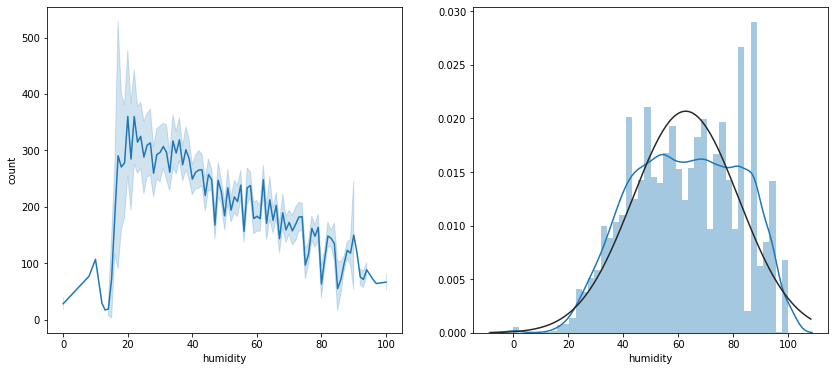

In [22]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.lineplot(data=all_data[:len(train)], x='humidity', y=Ytrain, ax=ax1)
sns.distplot(all_data['humidity'], fit=norm, ax=ax2)

### Windspeed

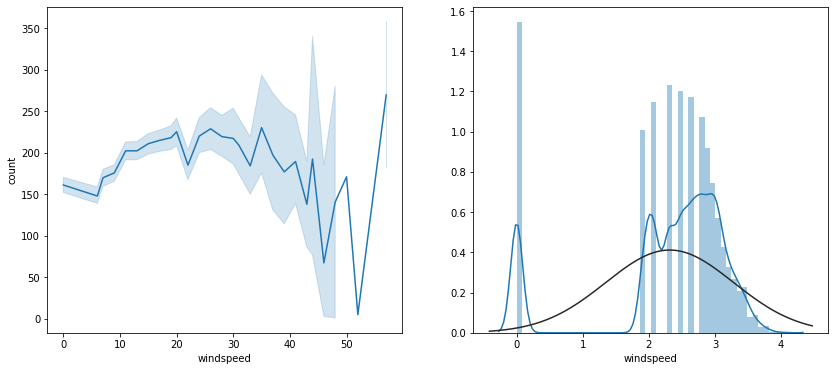

In [23]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.lineplot(data=all_data[:len(train)], x='windspeed', y=Ytrain, ax=ax1)
sns.distplot(np.log(all_data['windspeed']+1), fit=norm, ax=ax2)

In [24]:
all_data.loc[all_data['windspeed']==0, 'windspeed']=all_data['windspeed'].mean()

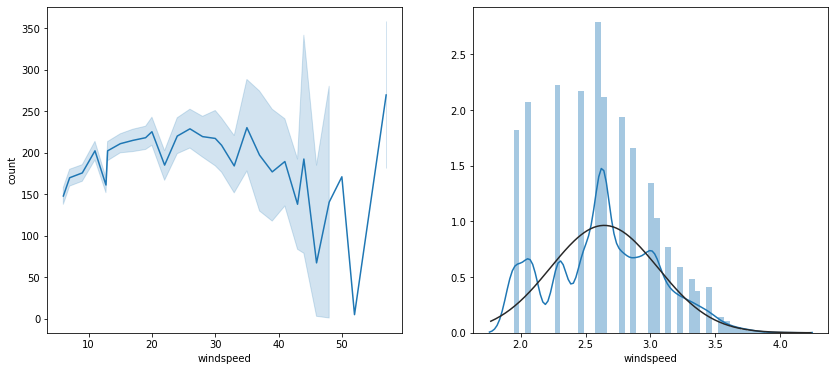

In [25]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.lineplot(data=all_data[:len(train)], x='windspeed', y=Ytrain, ax=ax1)
sns.distplot(np.log(all_data['windspeed']+1), fit=norm, ax=ax2)

### Build Models ★

In [26]:
Xtrain = all_data[:len(train)]
Xtest = all_data[len(train):]
Ytrain = np.log(Ytrain+1)
print(Xtrain.shape, Ytrain.shape, Xtest.shape)

(10886, 17) (10886,) (6493, 17)


이후 머신러닝의 내용은 추후에 다시 따라해볼 것

The code I used above is from here. https://www.kaggle.com/cuijamm/bike-sharing-demand-starter-code-score-0-37235